In [2]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

In [3]:
db_params = {
    'host': '194.171.191.226',
    'port': '6379',
    'database': 'postgres',
    'user': 'group23',
    'password': 'blockd_2024group23_14'
}

In [4]:
# Connect to the PostgreSQL database
conn = psycopg2.connect(**db_params)
cursor = conn.cursor()

In [5]:
# Function to check if a table exists in the database

# def check_table_exists(cursor, schema, table_name):
#     cursor.execute("""
#         SELECT EXISTS (
#             SELECT FROM information_schema.tables 
#             WHERE table_schema = %s 
#             AND table_name = %s
#         );
#     """, (schema, table_name))
#     return cursor.fetchone()[0]

###### IN CASE SOME CHANGES NEED TO BE DONE TO THE JOINED_TABLE THE CODE BELOW DELETES THE TABLE IF IT ALREADY EXISTS

# # # Drop previous version of joined_table if exists
# if check_table_exists(cursor, 'group23_warehouse', 'joined_table_final'):
#     cursor.execute("DROP TABLE group23_warehouse.joined_table_final;")
#     print("Previous version of joined_table_final dropped.")

cursor.execute("BEGIN;")

# Create precipitation_modified table if it doesn't exist
if not check_table_exists(cursor, 'group23_warehouse', 'precipitation_modified'):
    cursor.execute('''
        CREATE TABLE group23_warehouse.precipitation_modified AS
        SELECT 
            DATE(dtg) AS dtg, 
            AVG(dr_pws_10) AS precipitation_secs
        FROM data_lake.precipitation 
        GROUP BY DATE(dtg);
    ''')
    print("precipitation_modified table created.")

# Create joined_table by using accidents data table, safe driving table, and precipitation. 
# I'm also adding some conditions to the column town to only take the ones that contain Breda
cursor.execute('''
    CREATE TABLE group23_warehouse.joined_table_final AS 
    SELECT 
        ad."Road condition",
        ad."Road surface",
        ad."street",
        ad."weather",
        sd.event_start,
        sd.event_end,
        sd.duration_seconds,
        sd.speed_kmh,
        sd.end_speed_kmh,
        sd.maxwaarde,
        sd.category,
        sd.incident_severity,
        sd.place_name,
        sd.is_valid,
        sd.latitude,
        sd.longitude,
        pm.precipitation_secs
    FROM data_lake.accident_data_17_23 ad
    JOIN data_lake.safe_driving sd
        ON (ad."street" = sd."road_name"
        AND ad."Year" = EXTRACT(YEAR FROM sd.event_start::date))
    LEFT JOIN group23_warehouse.precipitation_modified pm
        ON (DATE(sd.event_start) = pm.dtg
        AND ((pm.precipitation_secs = 0 AND ad."Road condition" = 'Dry')
            OR (pm.precipitation_secs > 0 AND ad."Road condition" = 'Wet/damp')))
    WHERE sd.is_valid = 'True'
    AND pm.dtg >= '2018-01-01';
''')
print("joined_table_final created.")

cursor.execute("COMMIT;")

joined_table_final created.


In [5]:
# I'm fetching and displaying the contents of joined_table in this cell to avoid the kernel from crushing
cursor.execute("SELECT COUNT(*) FROM group23_warehouse.joined_table_final;")
row_count = cursor.fetchone()[0]
print(f"Number of rows in joined_table: {row_count}")

#100 rows from joined_table
cursor.execute("SELECT * FROM group23_warehouse.joined_table_final LIMIT 100;")
rows = cursor.fetchall()
column_names = [desc[0] for desc in cursor.description]
df = pd.DataFrame(rows, columns=column_names)

# Display the DataFrame
print(df.head())
display(df)

Number of rows in joined_table: 2295502
  Road condition     Road surface        street weather  \
0       Wet/damp  Asphalt (other)      Elleboog    Rain   
1       Wet/damp  Asphalt (other)   Lunetstraat     Dry   
2       Wet/damp  Asphalt (other)  Emerparklaan    Rain   
3       Wet/damp  Asphalt (other)  Emerparklaan    Rain   
4       Wet/damp  Asphalt (other)  Emerparklaan    Rain   

              event_start               event_end  duration_seconds  \
0 2018-01-27 18:30:11.400 2018-01-27 18:30:13.300               1.9   
1 2018-01-27 09:24:21.600 2018-01-27 09:24:22.900               1.3   
2 2018-01-27 14:04:40.500 2018-01-27 14:04:52.500              12.0   
3 2018-01-27 14:04:40.500 2018-01-27 14:04:52.500              12.0   
4 2018-01-27 14:04:40.500 2018-01-27 14:04:52.500              12.0   

   speed_kmh  end_speed_kmh  maxwaarde          category incident_severity  \
0  33.796223      22.530815   0.954341  HARSH CORNERING              HC1     
1  20.921473      22.5

,Road condition,Road surface,street,weather,event_start,event_end,duration_seconds,speed_kmh,end_speed_kmh,maxwaarde,category,incident_severity,place_name,is_valid,latitude,longitude,precipitation_secs
0,Wet/damp,Asphalt (other),Elleboog,Rain,2018-01-27 18:30:11.400,2018-01-27 18:30:13.300,1.9,33.796223,22.530815,0.954341,HARSH CORNERING,HC1,Breda,True,51.60394,4.723639,110.333333
1,Wet/damp,Asphalt (other),Lunetstraat,Dry,2018-01-27 09:24:21.600,2018-01-27 09:24:22.900,1.3,20.921473,22.530815,0.703283,HARSH CORNERING,HC1,Breda,True,51.59621,4.750157,110.333333
2,Wet/damp,Asphalt (other),Emerparklaan,Rain,2018-01-27 14:04:40.500,2018-01-27 14:04:52.500,12.0,62.764416,62.764416,64.373760,SPEED,SP1,Breda,True,51.60857,4.752278,110.333333
3,Wet/damp,Asphalt (other),Emerparklaan,Rain,2018-01-27 14:04:40.500,2018-01-27 14:04:52.500,12.0,62.764416,62.764416,64.373760,SPEED,SP1,Breda,True,51.60857,4.752278,110.333333
4,Wet/damp,Asphalt (other),Emerparklaan,Rain,2018-01-27 14:04:40.500,2018-01-27 14:04:52.500,12.0,62.764416,62.764416,64.373760,SPEED,SP1,Breda,True,51.60857,4.752278,110.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Wet/damp,Asphalt (other),Graaf Engelbertlaan,Dry,2018-01-27 10:55:59.500,2018-01-27 10:56:42.500,43.0,62.764416,64.373760,69.201790,SPEED,SP1,Breda,True,51.57175,4.772973,110.333333
96,Wet/damp,Asphalt (other),Graaf Engelbertlaan,Dry,2018-01-27 10:55:59.500,2018-01-27 10:56:42.500,43.0,62.764416,64.373760,69.201790,SPEED,SP1,Breda,True,51.57175,4.772973,110.333333
97,Wet/damp,Asphalt (other),Graaf Engelbertlaan,Dry,2018-01-27 10:55:59.500,2018-01-27 10:56:42.500,43.0,62.764416,64.373760,69.201790,SPEED,SP1,Breda,True,51.57175,4.772973,110.333333
98,Wet/damp,Porous asphalt,Terheijdenseweg,Dry,2018-01-27 11:39:24.000,2018-01-27 11:39:37.000,13.0,64.373760,62.764416,69.201790,SPEED,SP1,Breda,True,51.61520,4.772784,110.333333


['HARSH CORNERING' 'SPEED' 'BRAKING']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Road condition      100 non-null    object        
 1   Road surface        100 non-null    object        
 2   street              100 non-null    object        
 3   weather             100 non-null    object        
 4   event_start         100 non-null    datetime64[ns]
 5   event_end           100 non-null    datetime64[ns]
 6   duration_seconds    100 non-null    float64       
 7   speed_kmh           100 non-null    float64       
 8   end_speed_kmh       100 non-null    float64       
 9   maxwaarde           100 non-null    float64       
 10  category            100 non-null    object        
 11  incident_severity   100 non-null    object        
 12  place_name          100 non-null    object        
 13  is_valid     

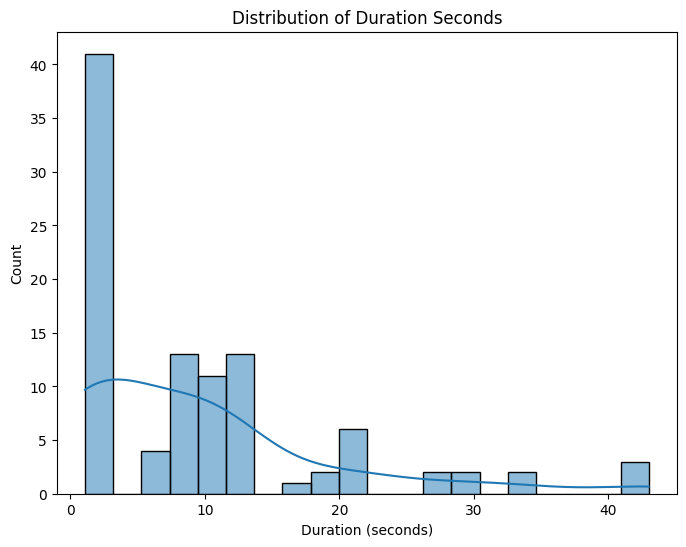

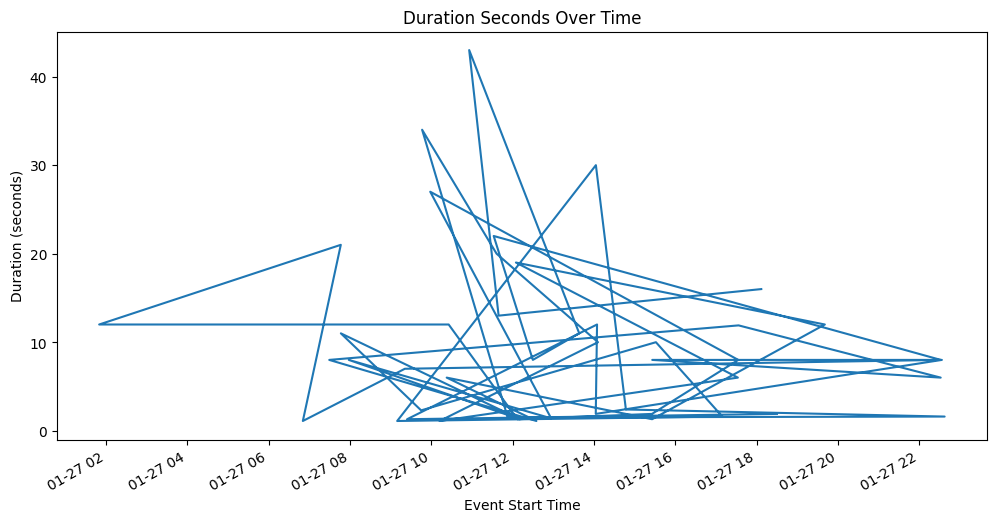

In [8]:
# This code removes whitespaces from the category column because we had two of each was not right
df['category'] = df['category'].str.strip()

# I'm merging the categories together based on the name
df['category'] = df['category'].replace({
    'HARSH CORNERING': 'HARSH CORNERING',
    'HARSH CORNERING ': 'HARSH CORNERING',
})

# Checking the unique values , data structure , summary and missing values , value counts for categories and incident_severity
print(df['category'].unique())
print(df.info())
print(df.describe())
print(df.isnull().sum())
print(df['category'].value_counts())
print(df['incident_severity'].value_counts())

# Visualizations to check how the data looks like 
# Histogram of duration_seconds
plt.figure(figsize=(8, 6))
sns.histplot(df['duration_seconds'], bins=20, kde=True)
plt.title('Distribution of Duration Seconds')
plt.xlabel('Duration (seconds)')
plt.ylabel('Count')
plt.show()

# Time series analysis - Duration seconds over event_start time
plt.figure(figsize=(12, 6))
df.set_index('event_start')['duration_seconds'].plot()
plt.title('Duration Seconds Over Time')
plt.xlabel('Event Start Time')
plt.ylabel('Duration (seconds)')
plt.show()

In [6]:
result3 = (
    df
    .query("is_valid == True")
    .groupby(['category', 'incident_severity'])
    .size()
    .reset_index(name='tot_count')
    .sort_values(by='tot_count', ascending=False))

# Merge the aggregated counts back into the original dataframe to retain all columns
final_result = df.merge(
    result3,
    on=['category', 'incident_severity'],
    how='left'
)

print("\nAggregated and Transformed Data:")
display(final_result)


Aggregated and Transformed Data:


,Road condition,Road surface,street,weather,event_start,event_end,duration_seconds,speed_kmh,end_speed_kmh,maxwaarde,category,incident_severity,place_name,is_valid,latitude,longitude,precipitation_secs,tot_count
0,Wet/damp,Asphalt (other),Elleboog,Rain,2018-01-27 18:30:11.400,2018-01-27 18:30:13.300,1.9,33.796223,22.530815,0.954341,HARSH CORNERING,HC1,Breda,True,51.60394,4.723639,110.333333,38
1,Wet/damp,Asphalt (other),Lunetstraat,Dry,2018-01-27 09:24:21.600,2018-01-27 09:24:22.900,1.3,20.921473,22.530815,0.703283,HARSH CORNERING,HC1,Breda,True,51.59621,4.750157,110.333333,38
2,Wet/damp,Asphalt (other),Emerparklaan,Rain,2018-01-27 14:04:40.500,2018-01-27 14:04:52.500,12.0,62.764416,62.764416,64.373760,SPEED,SP1,Breda,True,51.60857,4.752278,110.333333,57
3,Wet/damp,Asphalt (other),Emerparklaan,Rain,2018-01-27 14:04:40.500,2018-01-27 14:04:52.500,12.0,62.764416,62.764416,64.373760,SPEED,SP1,Breda,True,51.60857,4.752278,110.333333,57
4,Wet/damp,Asphalt (other),Emerparklaan,Rain,2018-01-27 14:04:40.500,2018-01-27 14:04:52.500,12.0,62.764416,62.764416,64.373760,SPEED,SP1,Breda,True,51.60857,4.752278,110.333333,57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Wet/damp,Asphalt (other),Graaf Engelbertlaan,Dry,2018-01-27 10:55:59.500,2018-01-27 10:56:42.500,43.0,62.764416,64.373760,69.201790,SPEED,SP1,Breda,True,51.57175,4.772973,110.333333,57
96,Wet/damp,Asphalt (other),Graaf Engelbertlaan,Dry,2018-01-27 10:55:59.500,2018-01-27 10:56:42.500,43.0,62.764416,64.373760,69.201790,SPEED,SP1,Breda,True,51.57175,4.772973,110.333333,57
97,Wet/damp,Asphalt (other),Graaf Engelbertlaan,Dry,2018-01-27 10:55:59.500,2018-01-27 10:56:42.500,43.0,62.764416,64.373760,69.201790,SPEED,SP1,Breda,True,51.57175,4.772973,110.333333,57
98,Wet/damp,Porous asphalt,Terheijdenseweg,Dry,2018-01-27 11:39:24.000,2018-01-27 11:39:37.000,13.0,64.373760,62.764416,69.201790,SPEED,SP1,Breda,True,51.61520,4.772784,110.333333,57


In [8]:
print(df['Road surface'].unique())
print(df['latitude'].count())
print(df['longitude'].count())

['Asphalt (other)' 'Unknown' 'Porous asphalt' 'Brick' 'Concrete']
100
100


In [9]:
# Save the DataFrame to a CSV file
df.to_csv('joined_table_final.csv', index=False)

In [10]:
# Close cursor and connection
cursor.close()
conn.close()